In [1]:
#%%capture
#!pip install cellworld==0.0.105
#!pip install tqdm
#!pip install pandas
#!pip install scipy
#!pip install rtree
#!pip install ipywidgets

In [2]:
from cellworld import *
import numpy as np
import matplotlib.pyplot as plt
import glob
from tqdm.notebook import tqdm
from ipywidgets import *
import pickle

In [3]:
def sparse_subset(points,r):
    """Return a maximal list of elements of points such that no pairs of
    points in the result have distance less than r."""
    result = []
    index = rtree.index.Index()
    for i, p in enumerate(points):
        px, py = p
        nearby = index.intersection((px - r, py - r, px + r, py + r))
        if all(dist(p, points[j]) >= r for j in nearby):
            result.append(p)
            index.insert(i, (px, py, px, py))
    return result

def get_vis(e):
    """Gets world visibility object from experiment object."""
    w = World.get_from_parameters_names('hexagonal','canonical',e.occlusions)
    occlusion_locations = w.cells.occluded_cells().get("location")
    occlusions_polygons = Polygon_list.get_polygons(occlusion_locations, w.configuration.cell_shape.sides, w.implementation.cell_transformation.size / 2, w.implementation.space.transformation.rotation + w.implementation.cell_transformation.rotation) # ploygon object
    vis = Location_visibility(occlusions_polygons)
    return vis,w

def get_vertices(e):
    """Gets unique vertices from all polygons."""
    # make a list of all polygon vertices
    w = World.get_from_parameters_names('hexagonal','canonical',e.occlusions)
    all_polygons = Polygon_list.get_polygons(w.cells.get('location'),w.configuration.cell_shape.sides, w.implementation.cell_transformation.size / 2, w.implementation.space.transformation.rotation + w.implementation.cell_transformation.rotation)
    x = []
    y = []
    for poly in all_polygons:
        x.append(poly.vertices.get('x'))
        y.append(poly.vertices.get('y'))
    x = np.hstack(x).reshape(1,-1).T
    y = np.hstack(y).reshape(1,-1).T
    verts = np.concatenate((x,y),axis=1)
    pts = verts.tolist()

    # get unique vertices, removing those closeby
    sparse_pts = sparse_subset(pts,0.01)
    sparse_arr = np.vstack(sparse_pts)
    return sparse_arr

def get_tiles(n,e):
    """Get nxn locations tiled across the world in experiment object, then removes tiles
    that are within obstacles in the world. (needs to Display the world to do so)"""
    # generate world tiles
    w = World.get_from_parameters_names('hexagonal','canonical',e.occlusions)
    x = np.linspace(0,1,n)
    xv,yv = np.meshgrid(x,x,indexing='ij')
    xv = xv.reshape(1,-1)
    yv = yv.reshape(1,-1)
    points = np.concatenate((xv,yv)).T
    
    # get the wall limits
    d = Display(w, fig_size=(1,1), padding=0, cell_edge_color="lightgrey")
    path = d.habitat_polygon.get_path()
    transform = d.habitat_polygon.get_patch_transform()
    newpath = transform.transform_path(path)
    polygon = mpatches.PathPatch(newpath)
    inside = []
    inside.append(~newpath.contains_points(points))

    # get the occlusion limits and remove points
    for poly in d.cell_polygons:
        if poly._facecolor[0]==0:
            path = poly.get_path()
            transform = poly.get_patch_transform()
            newpath = transform.transform_path(path)
            polygon = mpatches.PathPatch(newpath)
            inside.append(newpath.contains_points(points,radius=0.025))
    index = np.any(np.vstack(inside).T,axis=1)
    return points[~index,:]

def plot_tiles(pts,sparse_arr,e):
    a = 1
    w = World.get_from_parameters_names('hexagonal','canonical',e.occlusions)
    
    # display
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    d = Display(w, fig_size=(5,5), padding=0, cell_edge_color="lightgrey",ax=ax[0])
    ax[0].scatter(pts[:,0],pts[:,1],5,'g',alpha = a)
    ax[0].scatter(sparse_arr[:,0],sparse_arr[:,1],20,'m')

    Display(w, fig_size=(5,5), padding=0, cell_edge_color="lightgrey",ax=ax[1])
    ax[1].scatter(pts[:,0],pts[:,1],5,'g',alpha = a)
    ax[1].scatter(sparse_arr[:,0],sparse_arr[:,1],20,'m')
    ax[1].set_xlim((.25,.3))
    ax[1].set_ylim((.25,.3))
    return [fig,ax]

def compute_visibility(src,dst,vis):
    """returns a visibility graph (V) and angle graph (A) between every point in
    src and dst according to visibility object vis"""
    m = len(src)
    p = len(dst)
    V = np.empty((m,p))
    A = np.empty((m,p))
    for i in tqdm(range(m)):
        loci = Location(src[i,0],src[i,1])
        for j in range(p):
            locj = Location(dst[j,0],dst[j,1])
            V[i,j] = vis.is_visible(loci,locj)
            A[i,j] = to_degrees(loci.atan(locj))
    return V,A

## Load and Preprocess

[<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)]

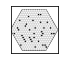

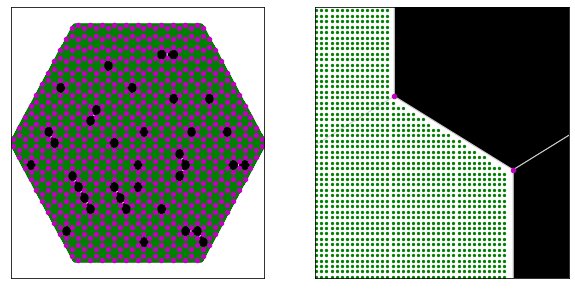

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [4]:
e = Experiment.load_from_file('./MICE_20220608_1557_DMM3_21_05_SR5_experiment.json')
vis,w = get_vis(e)
sparse_arr = get_vertices(e)
n = 1000
pts = get_tiles(n,e)
plot_tiles(pts,sparse_arr,e)

## Compute visibility graph
Between tile locations and vertices

In [5]:
filename = f'visibility-{e.occlusions}-{n}.pkl'
filepath = f'./{filename}'

if not glob.glob(filepath):
    print(f'Computing visibility graph using {n}x{n} resolution...')
    V,A = compute_visibility(pts,sparse_arr,vis)
    print(f'Saving visibility graph {filename}...')
    pickle.dump([A,V,pts,sparse_arr],open(filepath,'wb'))
    
else:
    print(f'Loading visibility graph {filename}...')
    [A,V,pts,sparse_arr] = pickle.load(open(filepath,'rb'))
    
vis_graph = {'V':V,'A':A,'src':pts,'dst':sparse_arr}

Loading visibility graph visibility-21_05-1000.pkl...


## Test ITOR
1. plot tiles
2. simulate head and tail pose
3. get nearest tile points

First define some functions:

In [6]:
def get_closest_tile(loc,vis_graph):
    """Get closest tile location to given location."""
    idx = cdist(loc.reshape(1,-1),vis_graph['src']).argmin()
    return vis_graph['src'][idx,:],idx

def get_fov_points(head_pt,head_angle,vis_graph,fov = np.rad2deg(1.74533)):
    """Get tiles within the FOV."""
    _,idx = get_closest_tile(head_pt,vis_graph)
    tA = np.deg2rad(vis_graph['A'][idx,:])
    sA = np.deg2rad(head_angle)
    a = np.min(np.concatenate(((2 * np.pi) - np.abs(tA - sA).reshape(-1,1),
                               np.abs(tA - sA).reshape(-1,1)),axis=1),axis=1)
    return (np.abs(np.rad2deg(a)) < fov)

def get_visibility(loc,vis_graph):
    """Returns which points are visible from the provided location"""
    pt,idx = get_closest_tile(loc,vis_graph)
    return (vis_graph['V'][idx,:]==1),pt
    

def compute_itor(pose,head_angle,vis_graph,head_parts=['head_base'],body_parts=['body_mid'],fov = np.rad2deg(1.74533)):
    """Returns ITOR value and various visible points in the environment based on
    pose, head angle, FOV"""
    # get closest tiles for each part:
    v = []
    ppoints = []
    for p in pose:
        vis,pt = get_visibility(np.array(pose[p]),vis_graph)
        v.append(vis)
        ppoints.append(pt)
    v = np.vstack(v)
    ppoints = np.vstack(ppoints)
    
    # get head and body parts
    head_ind = [i for i in range(len(list(pose.keys()))) if list(pose.keys())[i] in head_parts]
    body_ind = [i for i in range(len(list(pose.keys()))) if list(pose.keys())[i] in body_parts]
    
    # get points in the FOV
    fov_verts = get_fov_points(ppoints[head_ind,:],head_angle,vis_graph,fov)
    
    # which vertices that are visible to the head:
    vis_verts = np.any(v[head_ind,:],axis=0) & fov_verts
    
    # of FOV visible vertices, which ones are visible to the body:
    body_verts = np.any(v[body_ind,:],axis=0) & vis_verts
    
    # compute ITOR as 1-(visible_to_body/visible_to_head)
    ITOR = 1 - np.sum(body_verts)/np.sum(vis_verts)
    
    return {'ITOR':ITOR, 
            'vis_omni': np.any(v[head_ind,:],axis=0),
            'vis_head': vis_verts,
            'vis_body': body_verts,
            'head_parts': head_parts,
            'head_idx': head_ind,
            'body_parts': body_parts,
            'body_idx': body_ind,
            'pose_points': ppoints,
            'head_angle': head_angle}

    
    
    

# ITOR SIMULATOR

310.0


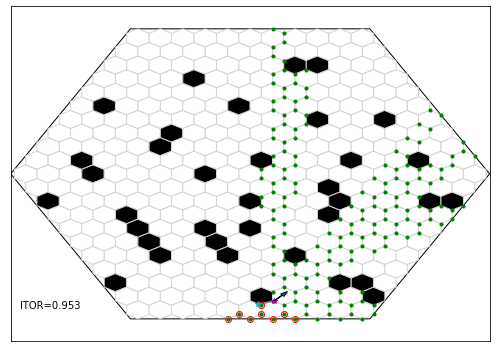

In [7]:
def plot_itor(I,vis_graph,w,ax,fig):
    # plot the world
    d = Display(w, fig_size=(7,9), padding=0, cell_edge_color="lightgrey",ax=ax,fig=fig)
    # plot the pose used to compute ITOR
    ppts = np.vstack(I['pose_points'])
    h0 = ax.arrow(ppts[I['head_idx'],0][0],ppts[I['head_idx'],1][0],
                  np.cos(np.deg2rad(90-I['head_angle']))*.025,
                  np.sin(np.deg2rad(90-I['head_angle']))*.025,head_width=.01,zorder=4)
    h1, = ax.plot(ppts[:,0],ppts[:,1],'grey',marker='.')
    h2, = ax.plot(ppts[I['head_idx'],0],
                  ppts[I['head_idx'],1],'m',marker='*',zorder=3)
    h3, = ax.plot(ppts[I['body_idx'],0],
                  ppts[I['body_idx'],1],'c',marker='*',zorder=3)
    h4, = ax.plot(vis_graph['dst'][I['vis_omni'],0],
                  vis_graph['dst'][I['vis_omni'],1],'g.',alpha=0.25)
    h5, = ax.plot(vis_graph['dst'][I['vis_head'],0],
                  vis_graph['dst'][I['vis_head'],1],'g.')
    h6, = ax.plot(vis_graph['dst'][I['vis_body'],0],
                  vis_graph['dst'][I['vis_body'],1],'ro',fillstyle='none')
    h7 = ax.text(0.02,0.1,f'ITOR={np.round(I["ITOR"],3)}')
    
    return h0,h1,h2,h3,h4,h5,h6,h7

def update_plot_itor(I,vis_graph):
    # get pose
    ppts = np.vstack(I['pose_points'])
    # plot
    global h0
    h0.remove()
    h0 = ax.arrow(ppts[I['head_idx'],0][0],ppts[I['head_idx'],1][0],
                  np.cos(np.deg2rad(90-I['head_angle']))*.025,
                  np.sin(np.deg2rad(90-I['head_angle']))*.025,head_width=.01,zorder=4)
    h1.set_xdata(ppts[:,0])
    h1.set_ydata(ppts[:,1])
    h2.set_xdata(ppts[I['head_idx'],0])
    h2.set_ydata(ppts[I['head_idx'],1])
    h3.set_xdata(ppts[I['body_idx'],0])
    h3.set_ydata(ppts[I['body_idx'],1])
    h4.set_xdata(vis_graph['dst'][I['vis_omni'],0])
    h4.set_ydata(vis_graph['dst'][I['vis_omni'],1])
    h5.set_xdata(vis_graph['dst'][I['vis_head'],0])
    h5.set_ydata(vis_graph['dst'][I['vis_head'],1])
    h6.set_xdata(vis_graph['dst'][I['vis_body'],0])
    h6.set_ydata(vis_graph['dst'][I['vis_body'],1])
    h7.set_text(f'ITOR={np.round(I["ITOR"],3)}')
    fig.canvas.draw()
    fig.canvas.draw_idle()
                      
def update_sim_pose(head_x=0.55,head_y=0.12,body_angle=180,head_angle=45,fov=np.rad2deg(1.74533)):
    pose = {'head_base':[head_x,head_y],
            'body_mid':[head_x+np.cos(np.deg2rad(body_angle))*0.03,
                        head_y+np.sin(np.deg2rad(body_angle))*0.03]}
    return pose,head_angle,fov
                      
    

# body update
# fov=np.rad2deg(1.74533)
fov = 310.0
pose,head_angle,fov = update_sim_pose(fov=fov)
print(fov)

# compute ITOR
I = compute_itor(pose,head_angle,vis_graph,fov=fov)

# plot
fig,ax = plt.subplots(1,1,figsize=(7,5))
h0,h1,h2,h3,h4,h5,h6,h7 = plot_itor(I,vis_graph,w,ax,fig)

<IPython.core.display.Javascript object>


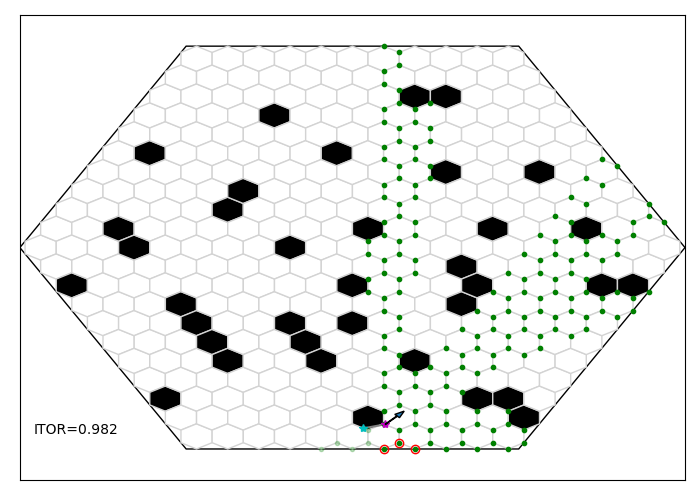

interactive(children=(IntSlider(value=45, description='head_angle', max=180, min=-180), IntSlider(value=180, d…

In [8]:
%matplotlib notebook

def update_sim(head_angle = 45, body_angle=180, head_x = 0.55, head_y = 0.12, fov = 310.0/2):
    # body update
    pose,head_angle,_ = update_sim_pose(head_x,head_y,body_angle,head_angle)

    # compute ITOR
    I = compute_itor(pose,head_angle,vis_graph,fov=fov)
    
    # update the plot
    update_plot_itor(I,vis_graph)

# settings
full_fov = np.rad2deg(1.74533)
binocular_fov = np.rad2deg(0.349066)

# body update
pose,head_angle,fov = update_sim_pose(fov = 310.0/2)

# compute ITOR
I = compute_itor(pose,head_angle,vis_graph,fov=fov)

# plot
fig,ax = plt.subplots(1,1,figsize=(7,5))
h0,h1,h2,h3,h4,h5,h6,h7 = plot_itor(I,vis_graph,w,ax,fig)


interact(update_sim,head_angle=widgets.IntSlider(min=-180, max=180, step=1, value=45),
        body_angle=widgets.IntSlider(min=0, max=360, step=1, value=180),
        head_x=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.55),
        head_y=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.12),
        fov=widgets.RadioButtons(options=[np.rad2deg(1.74533)+50,np.rad2deg(1.74533),np.rad2deg(0.349066)],description='FOV',disabled=False));


# POSE STATISTICS

We want to know:
1. What is the typical head-nose distance
2. Given a head direction, what are the limits of various body parts (rotate by head direction and look at distributions of other parts)

In [11]:
%matplotlib inline
# functions to extract pose data
class PoseList(JsonList):
  def __init__(self):
    super().__init__(list_type=PosePart)

class PosePart(JsonObject):
  def __init__(self):
    self.part = str()
    self.location = Location()
    self.camera = int()
    self.score = float()
    
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

def get_pose(step):
    p = PoseList.parse(step.data)
    pose = {}
    for i in range(len(p)):
        pose.update({p[i].part:[p[i].location.x,p[i].location.y]})
    return pose

def get_pose_angle(pose=[], parts=['head_base','nose']):
    posec = pose.copy()
    loca = [i.location for i in posec if i.part==parts[0]][0]
    locb = [i.location for i in posec if i.part==parts[1]][0]
    #loca.y = loca.y*-1
    #locb.y = locb.y*-1
    angle = to_degrees(loca.atan(locb))
    return angle

        

# poselist = PoseList.parse(t.get('data'))
# poselist[0].part
# poselist[0].location
# score threshold probably use .8

## Visualization

- plot pose distributions conditioned on head direction and position
- compute distribution of head lengths

In [12]:
# extract pose from data
POSEx = []
POSEy = []
SCORE = []
for ep in e.episodes:
    pt = ep.trajectories.where('agent_name','prey').get_unique_steps()
    for step in pt:
        posex = []
        posey = []
        score = []
        if step.data:
            pose = PoseList.parse(step.data)
            for i in range(len(pose)):
                posex.append(pose[i].location.x)
                posey.append(pose[i].location.y)
                score.append(pose[i].score)
            POSEx.append(posex)
            POSEy.append(posey)
            SCORE.append(score)
poseX = np.vstack(POSEx)
poseY = np.vstack(POSEy)
score = np.vstack(SCORE)

# remove bad scores
poseX[score < 0.8] = np.nan
poseY[score < 0.8] = np.nan

In [13]:
parts = ['body_mid','head_base','nose','tail_base','tail_post_base','tail_pre_tip','tail_tip']
order = np.array((6,5,4,3,0,1,2))
print(parts)

# parts to use for position and angle norms
norm_part = 'head_base'
rot_parts = [norm_part, 'nose'] #[norm_part,'body_mid']

['body_mid', 'head_base', 'nose', 'tail_base', 'tail_post_base', 'tail_pre_tip', 'tail_tip']


In [14]:
# normalize position
normI = parts.index(norm_part)
px_norm = poseX[:,:] - poseX[:,normI].reshape(-1,1)
py_norm = poseY[:,:] - poseY[:,normI].reshape(-1,1)
#_ = plt.plot(px_norm.T,py_norm.T)

# rotate
rotI = [parts.index(x) for i,x in enumerate(rot_parts)]
angle = np.rad2deg(np.arctan2(
    [py_norm[:,rotI[0]],py_norm[:,rotI[1]]],
    [px_norm[:,rotI[0]],px_norm[:,rotI[1]]])[1])

px_rot = np.empty((len(px_norm),len(parts)))
py_rot = np.empty((len(px_norm),len(parts)))
for i in range(len(px_norm)):
    pts = np.concatenate((px_norm[i,:].reshape(-1,1),py_norm[i,:].reshape(-1,1)),axis=1)
    pts_rot = rotate(pts,degrees=-angle[i])
    px_rot[i,:] = pts_rot[:,0]
    py_rot[i,:] = pts_rot[:,1]

0 6 body_mid
1 5 head_base
2 4 nose
3 3 tail_base
4 0 tail_post_base
5 1 tail_pre_tip
6 2 tail_tip


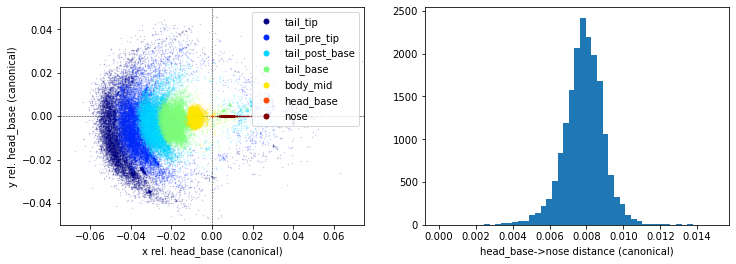

In [15]:
%matplotlib inline
fig,ax = plt.subplots(1,2,figsize=(12,4))

col = plt.cm.jet(np.linspace(0,1,7))
ax[0].axhline(0,color='k',linewidth=0.5,linestyle='--')
ax[0].axvline(0,color='k',linewidth=0.5,linestyle='--')
for i,o in enumerate(order):
    print(i,o,parts[i])
    ax[0].plot(px_rot[:,o],py_rot[:,o],'.',markersize=1,alpha=0.2,color=col[i])
    ax[0].plot(px_rot[0,o]+100,py_rot[0,o]+100,'.',markersize=10,alpha=1,color=col[i],label=parts[o])
ax[0].set_xlim([-0.075,0.075])
ax[0].set_ylim([-0.05,0.05])
ax[0].set_xlabel(f'x rel. {rot_parts[0]} (canonical)')
ax[0].set_ylabel(f'y rel. {rot_parts[0]} (canonical)')
ax[0].legend()

_ = ax[1].hist(px_rot[:,rotI[1]],bins=np.linspace(0,0.015,50))
ax[1].set_xlabel(f'{rot_parts[0]}->{rot_parts[1]} distance (canonical)')

fig.savefig('pose_stats.pdf')


## Random sampling

*Thinking out loud*: One way to sample would be to randomly mix pose points from all of the pose samples. However, this would inevitably lead to a strange mixture of pose relations that would not necessarily represent real poses.

*Some alternatives (from easiest to hardest)*:
- ignore most of the pose and only sample from "body_mid" distribution for ITOR bootstrap -- this would simplify ITOR calculation anyway and we don't have to worry about "realistic pose" because it is not contingent on chaining multiple parts together in a realistic way
- sample directly from all pose points (maybe excluding the current episode to avoid repeats) -- this would guarantee realistic poses
- learn some high dimensional pose space (ie. relationships between the parts, maybe via PCA) and create poses using weighted combinations of PCs plus noise?

... for now lets just build a pose library for this mouse

The library will have the following columns:

1. experiment name
2. episode
3. POSEx
4. POXEy
5. score


In [16]:
EXP = []
EPI = []
POSEx = []
POSEy = []
SCORE = []
POSE = []
for j,ep in enumerate(e.episodes):
    pt = ep.trajectories.where('agent_name','prey').get_unique_steps()
    for step in pt:
        posex = []
        posey = []
        score = []
        if step.data:
            pose = PoseList.parse(step.data)
            for i in range(len(pose)):
                posex.append(pose[i].location.x)
                posey.append(pose[i].location.y)
                score.append(pose[i].score)
            EXP.append(e.name)
            EPI.append(j)
            POSEx.append(posex)
            POSEy.append(posey)
            SCORE.append(score)
            POSE.append(pose)
experiment = np.vstack(EXP)
episodes = np.vstack(EPI)
poseX = np.vstack(POSEx)
poseY = np.vstack(POSEy)
score = np.vstack(SCORE)


Define ITOR from raw pose structure:

In [17]:
def compute_itor_pose(pose,head_angle,vis_graph,head_parts=['head_base'],body_parts=['body_mid'],fov = np.rad2deg(1.74533)):
    """Returns ITOR value pose points in the environment based on
    pose, head angle, FOV"""
    # get closest tiles for each part:
    v = []
    ppoints = []
    part = []
    for p in pose:
        if p.score > 0.8:
            part.append(p.part)
            vis,pt = get_visibility(np.array([p.location.x,p.location.y]),vis_graph)
            v.append(vis)
            ppoints.append(pt)
            
    if v:
        v = np.vstack(v)
        ppoints = np.vstack(ppoints)

        # get head and body parts
        head_ind = [i for i in range(len(part)) if part[i] in head_parts]
        body_ind = [i for i in range(len(part)) if part[i] in body_parts]

        if head_ind:
            # get points in the FOV
            fov_verts = get_fov_points(ppoints[head_ind,:],head_angle,vis_graph,fov)

            # which vertices that are visible to the head:
            vis_verts = np.any(v[head_ind,:],axis=0) & fov_verts

            # of FOV visible vertices, which ones are visible to the body:
            body_verts = np.any(v[body_ind,:],axis=0) & vis_verts

            # compute ITOR as 1-(visible_to_body/visible_to_head)
            ITOR = 1 - np.sum(body_verts)/np.sum(vis_verts)
            
        else:
            ITOR = np.nan
            ppoints = np.array([np.nan,np.nan])
    else:
        ITOR = np.nan
        ppoints = np.array([np.nan,np.nan])
    
    return {'ITOR':ITOR,
            'pose_points': ppoints}

def plot_pose(pose,ax=plt,**plt_kwargs):
    ppoints = []
    npoint = []
    hpoint = []
    for p in pose:
        if 'nose' in p.part:
            npoint = [p.location.x,p.location.y]
        elif 'head' in p.part:
            hpoint = [p.location.x,p.location.y]
        else:
            ppoints.append([p.location.x,p.location.y])
    ppoints = np.vstack(ppoints)
    hpoint = np.hstack(hpoint)
    npoint = np.hstack(npoint)
    h = []
    h.append(ax.scatter(ppoints[:,0],ppoints[:,1],**plt_kwargs))
    h.append(ax.plot(hpoint[0],hpoint[1],'*',color=h[0].get_facecolors()[0]))
    h.append(ax.plot(npoint[0],npoint[1],'^',color=h[0].get_facecolors()[0]))
    return(h)

def transform_pose(pose, origin=Location(0,0), offset=Location(0,0), angle=0):
    '''Transforms a pose object by offsetting and rotating around an origin'''
    pose_norm = pose.copy()
    for i,p in enumerate(pose_norm):
        p.location = p.location + offset
        r = rotate([p.location.x,p.location.y], 
                   origin=[origin.x,origin.y], 
                   degrees=-angle)
        p.location = Location(r[0],r[1])
    return pose_norm
    
    

def match_pose(pose0,pose1,ref_part='head_base'):
    '''Transforms pose1 to match pose0 based on reference part location and head angle'''
    # get reference location and angle
    ref_loc = [i.location for i in pose0 if i.part==ref_part][0]
    ref_angle = get_pose_angle(pose0)
    
    # get the source location and angle
    src_loc = [i.location for i in pose1 if i.part==ref_part][0]
    src_angle = get_pose_angle(pose1)
    
    # calculate location and angle offset
    a = ref_angle - src_angle
    if a > 180:
        a -= 360
    if a < -180:
        a += 360
    offset = (ref_loc - src_loc)
    
    # offset and rotate
    pose_norm = transform_pose(pose1,origin=ref_loc,offset=offset,angle=a)
    
    return pose_norm,src_angle,src_loc,ref_angle,ref_loc



frame 184 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 185 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 186 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 187 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 188 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 189 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 190 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 191 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 192 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 193 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 194 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 195 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 196 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 197 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 198 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 199 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 200 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 201 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 202 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 203 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 204 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 205 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 206 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 207 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 208 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 209 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 210 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 211 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 212 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 213 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 214 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 215 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 216 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 217 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 218 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 219 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 220 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 221 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 222 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 223 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 224 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 225 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 226 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 227 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 228 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 229 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 230 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 231 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 232 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 233 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 234 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 235 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 236 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 237 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 238 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 239 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 240 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 241 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 242 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 243 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 244 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 245 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 246 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 247 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 248 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 249 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 250 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 251 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 252 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 253 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 254 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 255 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 256 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 257 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 258 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 259 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 260 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 261 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 262 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 263 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 264 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 265 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 266 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 267 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 268 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 269 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 270 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 271 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 272 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 273 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 274 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 275 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 276 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 277 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 278 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 279 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 280 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 281 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 282 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 283 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 284 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 285 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 286 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 287 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 288 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 289 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 290 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 291 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 292 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 293 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 294 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 295 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 296 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 297 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 298 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 299 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 300 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 301 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 302 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 303 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 304 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 305 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 306 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 307 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 308 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 309 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 310 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 311 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 312 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 313 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 314 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 315 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 316 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 317 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 318 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 319 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 320 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 321 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 322 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 323 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 324 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 325 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 326 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 327 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 328 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 329 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 330 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 331 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 332 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 333 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 334 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 335 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 336 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 337 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 338 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 339 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 340 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 341 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 342 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 343 / 345


  0%|          | 0/500 [00:00<?, ?it/s]

frame 344 / 345


TypeError: wrong type for json_list

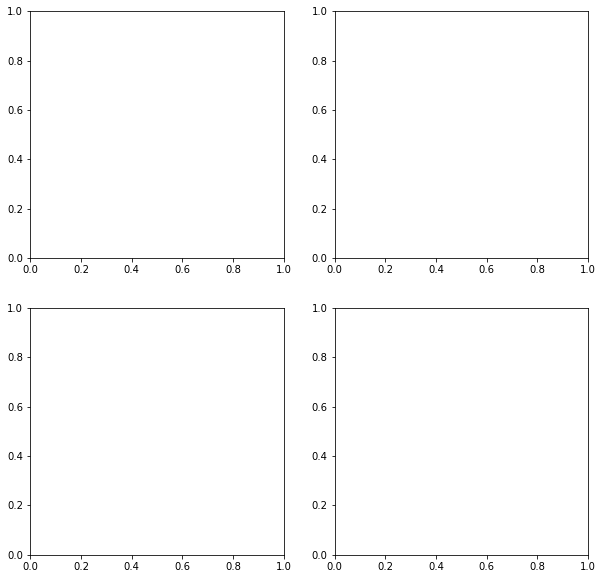

In [20]:
from random import choices
import matplotlib.colors as colors
import matplotlib.cm as cmx

# set episode, samples etc
k = 500
episode = 14
pt = e.episodes[episode].trajectories.where('agent_name','prey').get_unique_steps()
rt = e.episodes[episode].trajectories.where('agent_name','predator')
duration = len(pt) / 30 # convert to time

def make_frame(ind):
    
    print(f'frame {ind} / {len(pt)}')
    fig,ax = plt.subplots(2,2,figsize=(10,10))
    
    # copy original pose
    step = pt[ind]
    pose = PoseList.parse(step.data)
    pose0 = pose.copy()
    
    # plot each display
    d0 = Display(w, fig_size=(7,9), padding=0, cell_edge_color="lightgrey",fig=fig,ax=ax[0,0])
    d1 = Display(w, fig_size=(7,9), padding=0, cell_edge_color="lightgrey",fig=fig,ax=ax[0,1])
    
    # set the colormap
    cm = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0,vmax=1)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    
    # sample and plot random poses
    itor = []
    h = []
    for kk in tqdm(range(k)):

        # get a pose draw
        rand_sample = choices(np.where(episodes != episode)[0],k=1)
        pose1 = POSE[rand_sample[0]].copy()

        # offset and rotate each point
        pose_norm,src_angle,src_loc,ref_angle,ref_loc = match_pose(pose0,pose1)

        # compute ITOR and map to color value
        I = compute_itor_pose(pose_norm,
                          ref_angle,
                          vis_graph,
                          head_parts=['head_base'],
                          body_parts=['body_mid'])
        itor.append(I['ITOR'])
        cval = scalarMap.to_rgba(I['ITOR'])
        h = plot_pose(pose_norm,ax=ax[0,0],color=cval,alpha=0.1)
        h = plot_pose(pose_norm,ax=ax[0,1],color=cval,alpha=0.1)
        
    h = plot_pose(pose0,ax=ax[0,0],color='w')
    ax[0,0].axis('scaled')
    ax[0,0].set_xlabel('x')
    ax[0,0].set_ylabel('y')
    ax[0,0].set_xlim([-0.1,1.1])
    ax[0,0].set_ylim([-0.1,1.1])
    plt.setp(h[0],edgecolor='k',sizes=[15])
    plt.setp(h[1],markeredgecolor='k',ms=5)
    plt.setp(h[2],markeredgecolor='k',ms=3)
    #plt.savefig('./shuffled_pose_ex.pdf')
    
    # get robot for this frame and plot
    rind = np.where(np.array(rt.get('frame'))==step.frame)[0]
    if len(rind) > 0:
        # update location
        rloc = rt[rind[0]].location
        ax[0,0].plot(rloc.x,rloc.y,'rD',markersize=10)
        ax[0,1].plot(rloc.x,rloc.y,'rD',markersize=10)

    h = plot_pose(pose0,ax=ax[0,1],color='w')
    ax[0,1].axis('scaled')
    ax[0,1].set_xlim([ref_loc.x-0.1,ref_loc.x+0.1])
    ax[0,1].set_ylim([ref_loc.y-0.1,ref_loc.y+0.1])
    ax[0,1].set_xlabel('x')
    ax[0,1].set_ylabel('y')
    plt.setp(h[0],edgecolor='k',sizes=[50])
    plt.setp(h[1],markeredgecolor='k',ms=15)
    plt.setp(h[2],markeredgecolor='k',ms=12)
    plt.colorbar(scalarMap,ax=ax[0,1])

    ax[1,0].plot(ITOR,label='ITOR(t)')
    ax[1,0].axvline(ind,color='r',label='true pose')
    ax[1,0].set_xlabel('frame')
    ax[1,0].set_ylabel('ITOR')
    ax[1,0].set_ylim((0,1))
    ax[1,0].legend()
    ax[1,0].set_title(f'frame {ind}')

    ax[1,1].hist(itor,bins=np.linspace(0,1,30),label='random pose')
    ax[1,1].axvline(ITOR[ind],color='r',label='frame')
    ax[1,1].set_ylabel('count')
    ax[1,1].set_xlabel('ITOR')
    ax[1,1].set_xlim([0,1])
    ax[1,1].set_ylim([0,500])
    ax[1,1].legend()
    ax[1,1].set_title(f'percentile = {np.sum(np.array(itor)<=ITOR[ind])/np.sum(~np.isnan(np.array(itor)))}')

    fig.savefig(f'./episode{episode}/frame_{ind:03d}.jpeg')
    plt.close()
    
start = 184
for i in range(start,len(pt)):
    make_frame(i)

In [18]:
from random import choices

episode = 14
k = 1 #500

filename = f'./ep{episode}_{k}null.pkl'

if not glob.glob(filename):
    # for each step in the trajectory, compute true ITOR val
    pt = e.episodes[episode].trajectories.where('agent_name','prey').get_unique_steps()
    # body_parts=['body_mid','tail_base','tail_post_base','tail_pre_tip','tail_tip']
    body_parts=['body_mid']
    ITOR = []
    ITOR_null = []
    for i in tqdm(range(len(pt))):
        step = pt[i]
        if step.data:
            pose = PoseList.parse(step.data)

            # compute true ITOR
            I = compute_itor_pose(pose,
                      step.rotation,
                      vis_graph,
                      head_parts=['head_base'],
                      body_parts=body_parts)
            ITOR.append(I['ITOR'])

            # compute null itor
            rand_sample = choices(np.where(episodes != episode)[0],k=k)
            I_null = []
            for j in rand_sample:
                pose = POSE[j]
                I = compute_itor_pose(pose,
                      step.rotation,
                      vis_graph,
                      head_parts=['head_base'],
                      body_parts=body_parts)
                I_null.append(I['ITOR'])
            ITOR_null.append(I_null)
    pickle.dump([ITOR,ITOR_null,episode,POSE],open(filename,'wb'))
else:
    [ITOR,ITOR_null,episode,POSE] = pickle.load(open(filename,'rb'))
            

In [ ]:
%matplotlib notebook
cvec = np.array(ITOR)
cvec[np.isnan(cvec)] = 0
order = np.argsort(cvec)
partI = [1]
cvec = np.repeat(cvec.reshape(-1,1),len(partI),axis=1)
x = poseX[np.where(episodes==episode)[0],partI]
y = poseY[np.where(episodes==episode)[0],partI]
c = cvec
plt.scatter(x=x[order],y=y[order],c=c[order],s=10,cmap='jet')
plt.clim([0,1])
plt.colorbar()

In [ ]:
%matplotlib notebook
# get pose for the current episode
[ITOR,ITOR_null,episode,POSE] = pickle.load(open(filename,'rb'))
pose = [POSE[i] for i in np.where(episodes==episode)[0]]
ITOR = np.vstack(ITOR)
ITOR_null = np.vstack(ITOR_null)

# remove nan
ITOR_null = ITOR_null[~np.isnan(ITOR).squeeze(),:]
ITOR = ITOR[~np.isnan(ITOR)]

sortv = np.sort(ITOR)[::-1]
I = np.argsort(ITOR)[::-1]
plt.hist(ITOR_null[I[10]],50)
plt.axvline(ITOR[I[10]])


In [ ]:
I[0]

In [ ]:
ITOR_null.shape

In [ ]:
ITOR[~np.isnan(ITOR)]